In [1]:
## LOAD DATA

# Use pre-saved weights
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from utilsHannes import CoverNetNoRelu
import torch
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import numpy as np

# Load data
version = "v1.0-mini" # v1.0-mini, v1.0-trainval
if version == "v1.0-mini":
    train_subset = "mini_train"
    val_subset = "mini_val"
elif version == "v1.0-trainval":
    train_subset = "train"
    val_subset = "val"
     
DATAROOT = "data/sets/nuscenes"
seconds_of_history_used = 2.0 # Half second steps

sequences_per_instance = "one_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list1 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "non_overlapping_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list2 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")

sequences_per_instance = "all_sequences_per_instance" # one_sequences_per_instance, non_overlapping_sequences_per_instance, all_sequences_per_instance
img_tensor_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_img_tensor_list.pt")
agent_state_vector_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_agent_state_vector_list.pt")
future_xy_local_list3 = torch.load(f"dataLists/{version}/{sequences_per_instance}/{seconds_of_history_used}/train_future_xy_local_list.pt")


# Model
backbone = ResNetBackbone('resnet50')
covernet = CoverNetNoRelu(backbone, num_modes=64)


/opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/envs/flowerNuscenes/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
## SPECIFY FILE AND MODEL
num_epochs = 20
seconds_of_history_used = 2.0
sequences_per_instance = "one_sequences_per_instance"
file_path = f"tmpResults/results_epochs={num_epochs}_seconds_of_history_used={seconds_of_history_used}_{sequences_per_instance}"

# Load weights
covernet = copy.copy(covernet)
covernet.load_state_dict(torch.load(f'{file_path}_weights.pth'))


<All keys matched successfully>

Shape of set of all trajectories = (64, 12, 2)


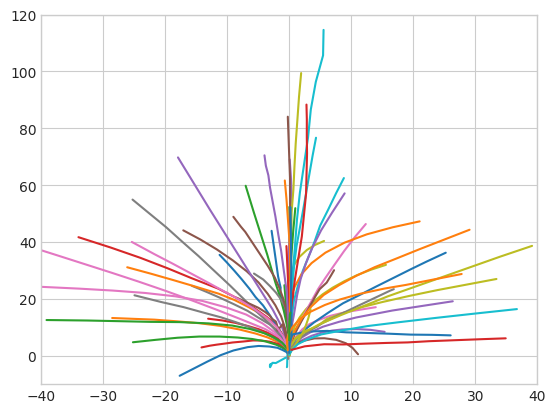

outputyValues = [0.05984064 0.11508735 0.1140011  0.0696841  0.06573922 0.01059091
 0.01101935 0.00035035 0.00419743 0.00651372 0.06207197 0.00853399
 0.02362239 0.014827   0.00625957 0.00563058 0.00732539 0.09644585
 0.00163523 0.02704341 0.00032055 0.00588528 0.01210992 0.00200033
 0.00310295 0.02149101 0.00749805 0.0003449  0.02053505 0.02435902
 0.01252399 0.00030654 0.00213724 0.00031483 0.00031518 0.00458386
 0.00785587 0.00877425 0.00033317 0.00034161 0.00197736 0.00032817
 0.00034415 0.01000695 0.00032906 0.00163284 0.00034026 0.01391095
 0.001621   0.00032869 0.00184749 0.01416819 0.00031905 0.00031984
 0.0037621  0.00375243 0.00380693 0.05358443 0.03077107 0.00032708
 0.00413832 0.00031817 0.00617948 0.00033284]
topProbabilitiesIndices = [ 1  2 17  3  4]


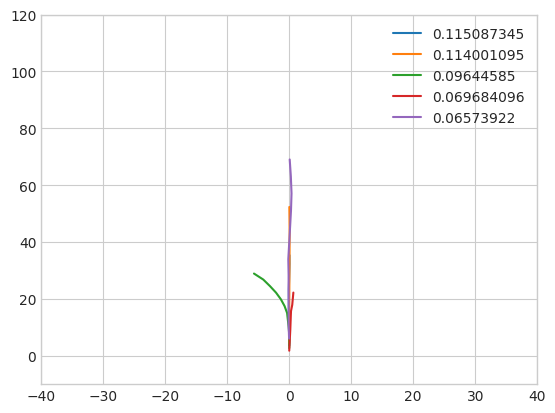

In [3]:
## PRINT PREDICTIONS
test_index =29

# Load trajectories
with open('data/sets/nuscenes-prediction-challenge-trajectory-sets/epsilon_8.pkl', 'rb') as f:
    trajectories = pickle.load(f)

### All trajectories
allTrajectories = np.array(trajectories)
print(f"Shape of set of all trajectories = {allTrajectories.shape}")

# Plot all trajectories
modes = np.arange(allTrajectories.shape[0])
timesteps = np.arange(12) # 12 timesteps (which is maximum), can be reduced
for mode in modes:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
plt.show()


### Get probabilities
logits = covernet(img_tensor_list1[test_index], agent_state_vector_list1[test_index])
softmaxy = torch.nn.Softmax(dim=1)
outputy = softmaxy(logits)
outputyValues = outputy.detach().numpy().squeeze()
# print(f"logits = {logits}")
# print(f"outputy.detach() = {outputy.detach()}")
# print(f"torch.sum(outputy).item() = {torch.sum(outputy).item()}")
print(f"outputyValues = {outputyValues}")


### Top trajectories
nrOfTopTrajectories = 5

topProbabilitiesIndices = np.argsort(outputyValues)[::-1][0:nrOfTopTrajectories]
print(f"topProbabilitiesIndices = {topProbabilitiesIndices}")
topProbabilities = []
[topProbabilities.append(outputyValues[index]) for index in topProbabilitiesIndices]


for mode in topProbabilitiesIndices:
    plt.plot(allTrajectories[mode,timesteps,0],allTrajectories[mode,timesteps,1])
plt.ylim([-10,120])
plt.xlim([-40,40])
plt.legend(topProbabilities)
plt.show()
